In [79]:
import os
from os.path import join
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

In [20]:
import trading as trd
from trading import StockPair, State, MODEL_LOC, NOTHING_DIR, REBAL_DIR, Q_PORT_DIR

In [65]:
# relaod module after modifying it
import importlib
importlib.reload(trd)
importlib.reload(trd.stock_history)
importlib.reload(trd.portfolio)
importlib.reload(trd.benchmarks)
importlib.reload(trd.rl)
importlib.reload(trd.nn)
importlib.reload(trd)

<module 'trading' from 'C:\\Users\\hamza\\Documents\\school\\cs_229\\cs229_final_project\\src\\trading\\__init__.py'>

In [8]:
MODEL_DIR = '7days_sharpe_reward_100h_relu_15eps'
MODEL_DIR = join(MODEL_LOC, MODEL_DIR)

## Portfolio Setup

In [9]:
# all the model and peoftolio parameters
theta = pickle.load(open(join(MODEL_DIR, "theta.p"), "rb" ))

In [11]:
# rebalance frequency
rebalance_period = 30

## Load Test Set (per the model)

In [12]:
# load the test set stock pairs from the saved file
stock_pairs = []

with open(join(MODEL_DIR, 'test.csv'), 'r') as f:
    for line in f:
        (L, H) = line.strip().split(',')
        hist_lo = trd.read_stock_history(join(trd.LO_BETA_DIR, L + '.csv'))
        hist_hi = trd.read_stock_history(join(trd.HI_BETA_DIR, H + '.csv'))

        stock_pairs.append(StockPair(L, H, hist_lo, hist_hi))

In [14]:
test_states = [State(p, cash=theta['cash'], 
                     target_weights=theta['starting_weights'],
                     trans_cost=theta['trans_cost'], 
                     d=theta['d']) for p in stock_pairs]
available_test_states = test_states[:]

In [16]:
assert len(test_states) == theta['m_test']

## Load the Model

In [15]:
model = load_model(join(MODEL_DIR, 'model.h5'))

## Evaluate Model

In [17]:
# run the model on each test portfolio
while True:
    if available_test_states == []:
        break
    
    states = np.array([st.state for st in available_test_states])
 
    qvalues = model.predict(states)
    chosen_actions = np.argmax(qvalues, axis=1)
    
    for (st, a) in zip(available_test_states, trd.actions[chosen_actions]):
        # execute the action
        st.execute_trade(a)

        try:
            st.step()
        except StopIteration:
            available_test_states.remove(st)

In [22]:
# save off the test runs
for st in test_states:
    file_name = '{:s}_{:s}.csv'.format(st.lo.symbol, st.hi.symbol)
    st.portfolio.to_csv(join(MODEL_DIR, Q_PORT_DIR, file_name))

## Run Benchmarks

In [30]:
do_nothing_portfolios = []
rebalance_portfolios = []

for st in stock_pairs:
    nothing = trd.do_nothing_benchmark(st.hist_lo, st.hist_hi, 
                                       initial_value=theta['cash'],
                                       trans_cost=theta['trans_cost'])
    rebal = trd.rebalance_benchmark(st.hist_lo, st.hist_hi, rebalance_period=rebalance_period, 
                                    initial_value=theta['cash'], 
                                    trans_cost=theta['trans_cost'])
    
    do_nothing_portfolios.append(nothing)
    rebalance_portfolios.append(rebal)
    
    nothing.to_csv(join(MODEL_DIR, NOTHING_DIR, '{:s}_{:s}.csv'.format(st.lo, st.hi)))
    rebal.to_csv(join(MODEL_DIR, REBAL_DIR, '{:s}_{:s}.csv'.format(st.lo, st.hi)))


In [35]:
assert len(test_states) == len(do_nothing_portfolios)
assert len(do_nothing_portfolios) == len(rebalance_portfolios)

In [36]:
def cust_plt(ax, data, label='', **kwargs):
    ax.plot_date(data.index, data, ls='solid', marker='', label=label, **kwargs)

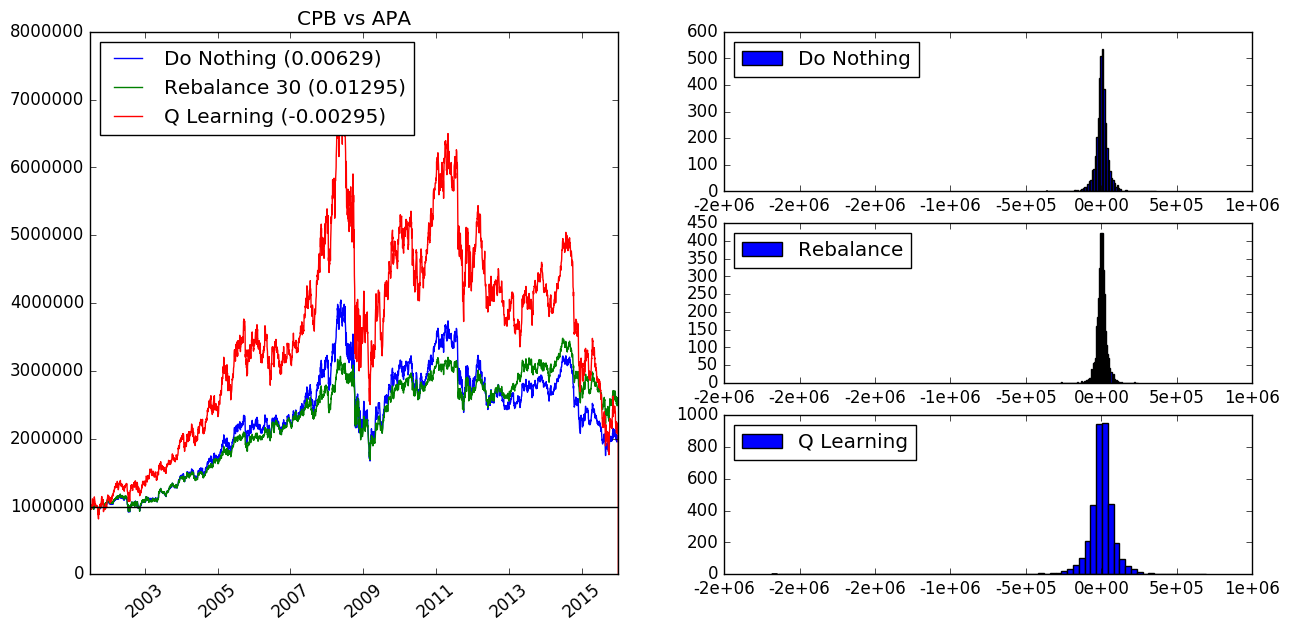

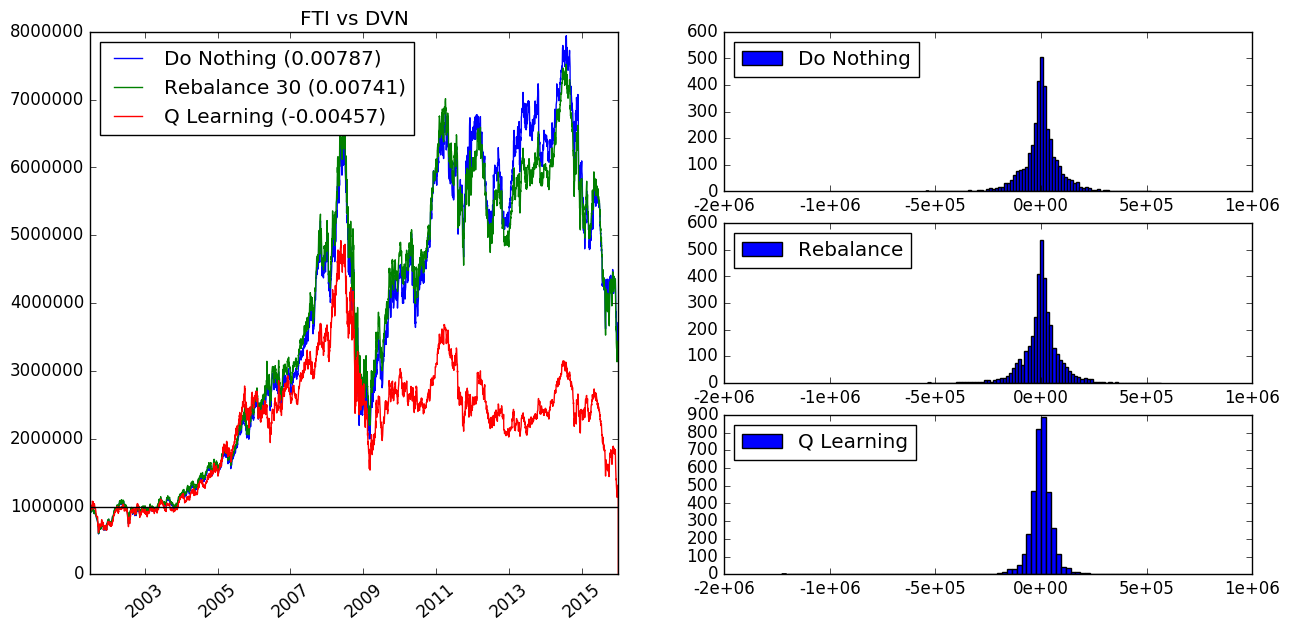

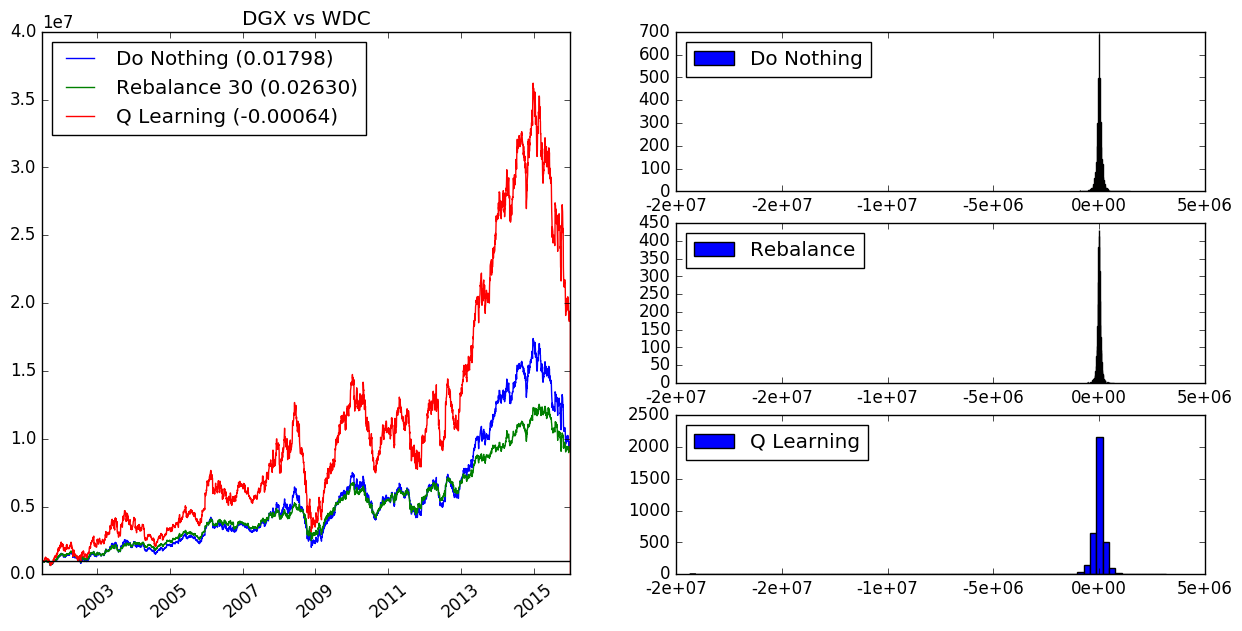

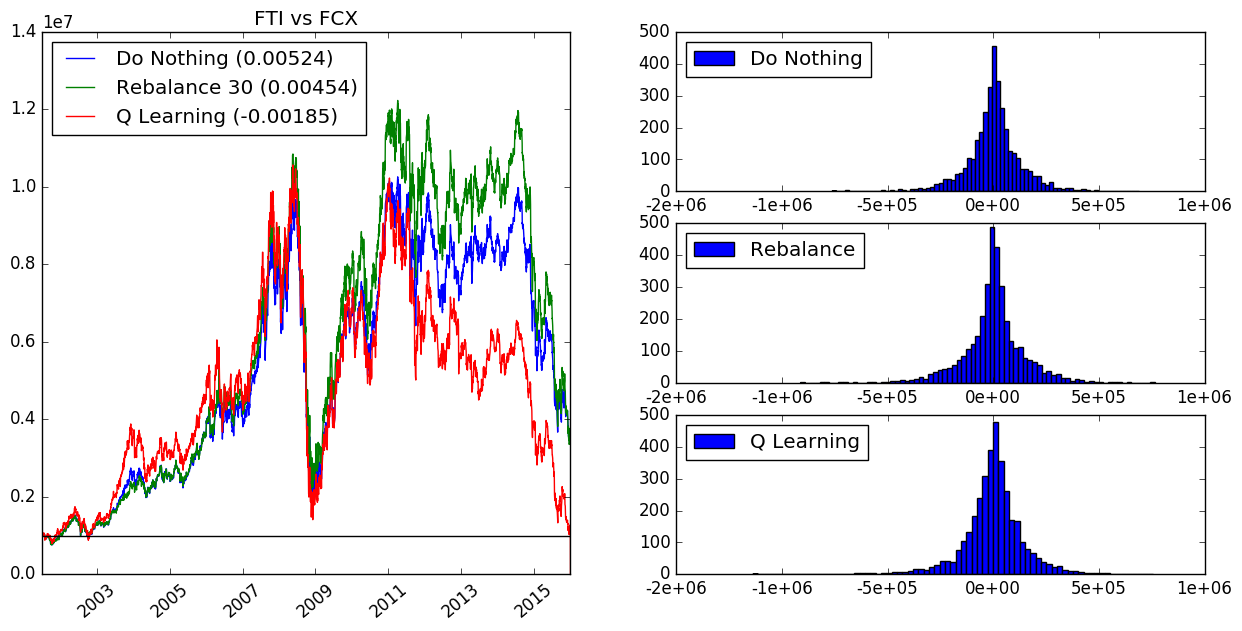

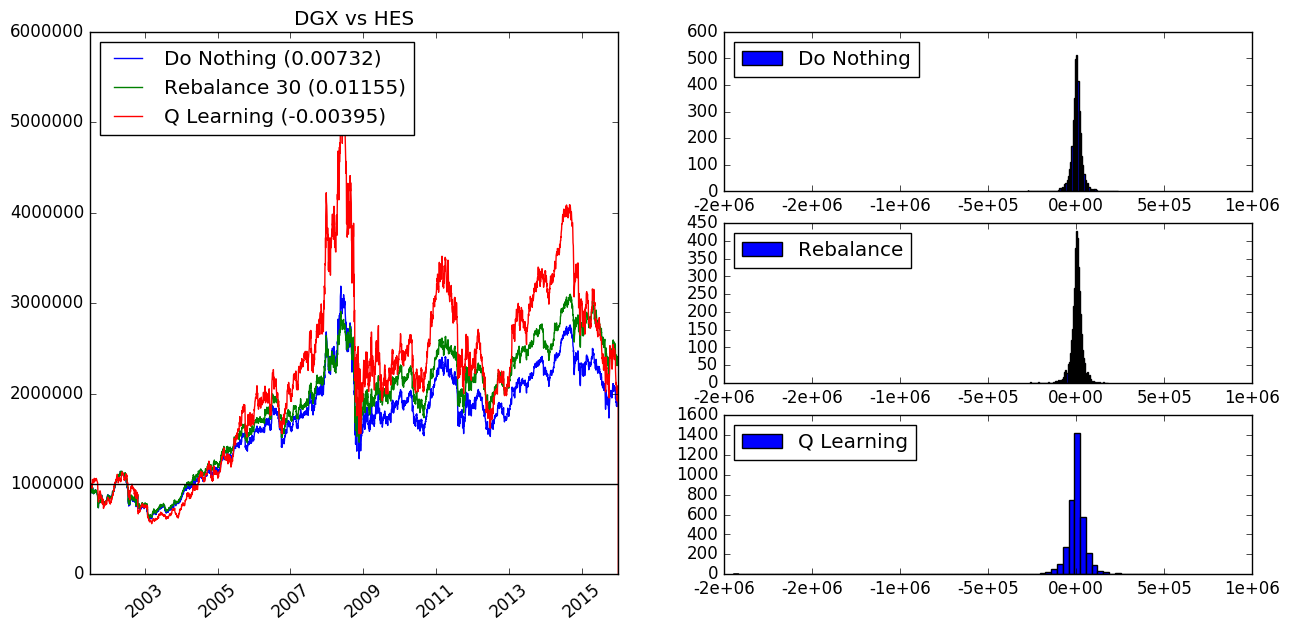

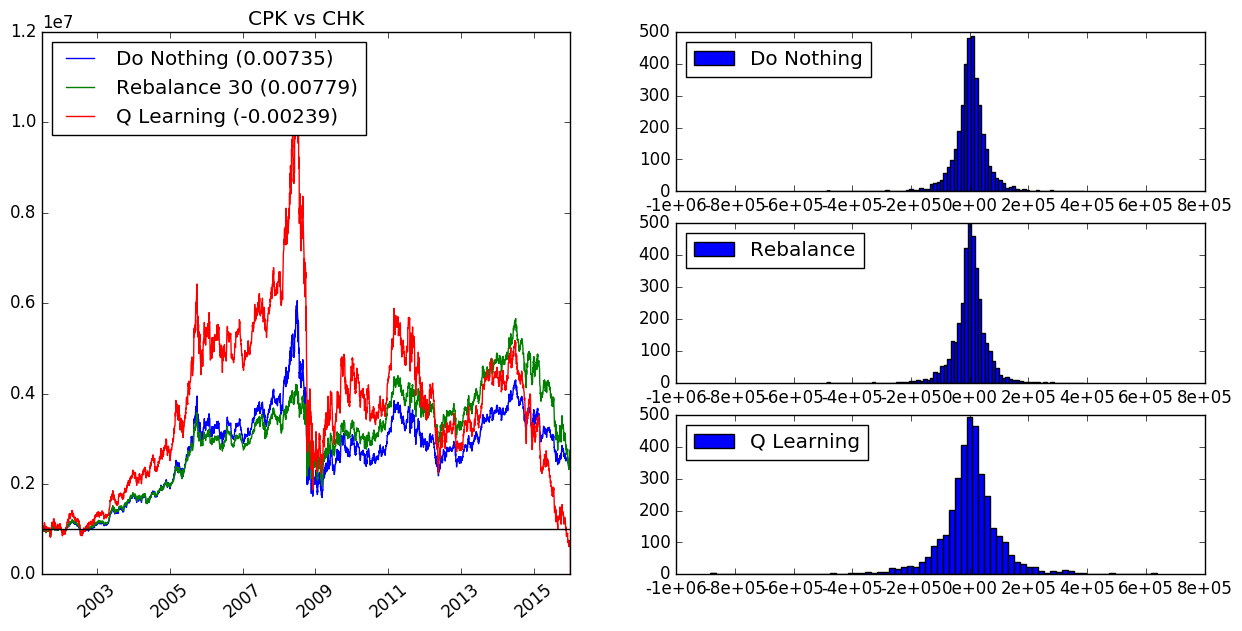

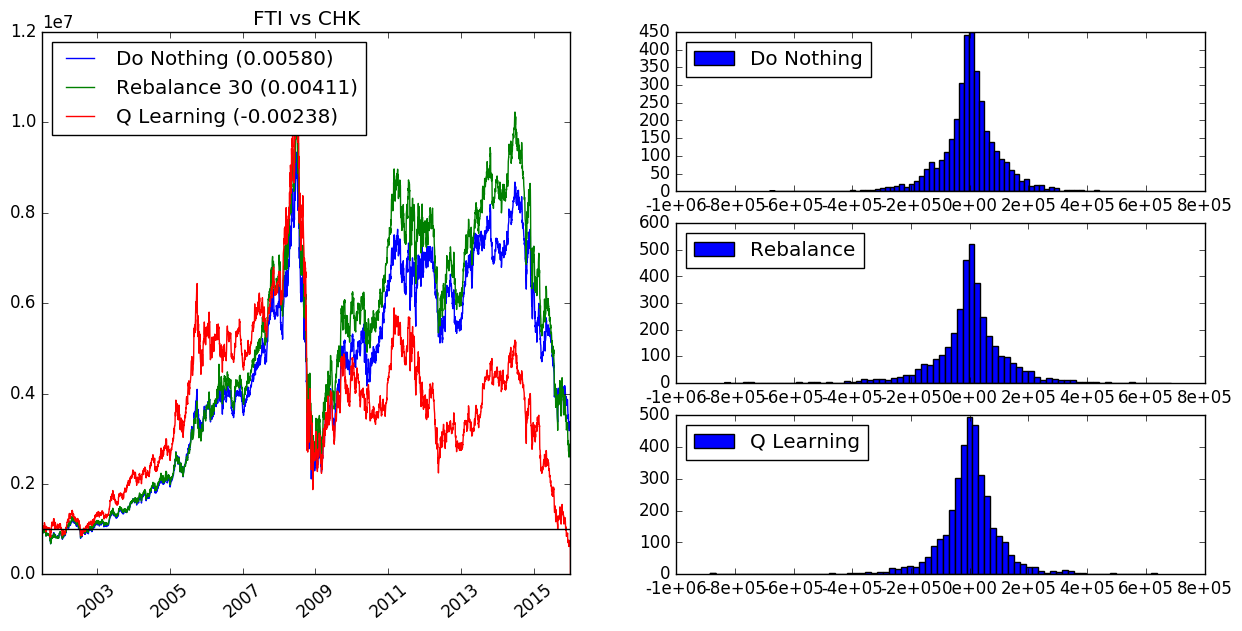

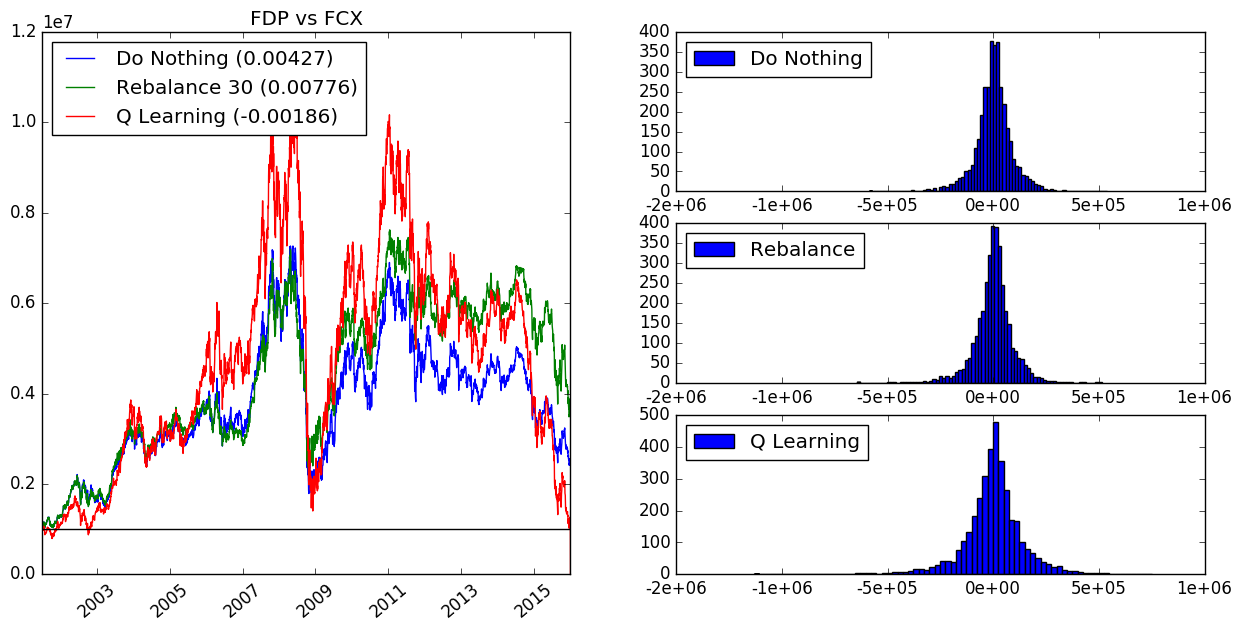

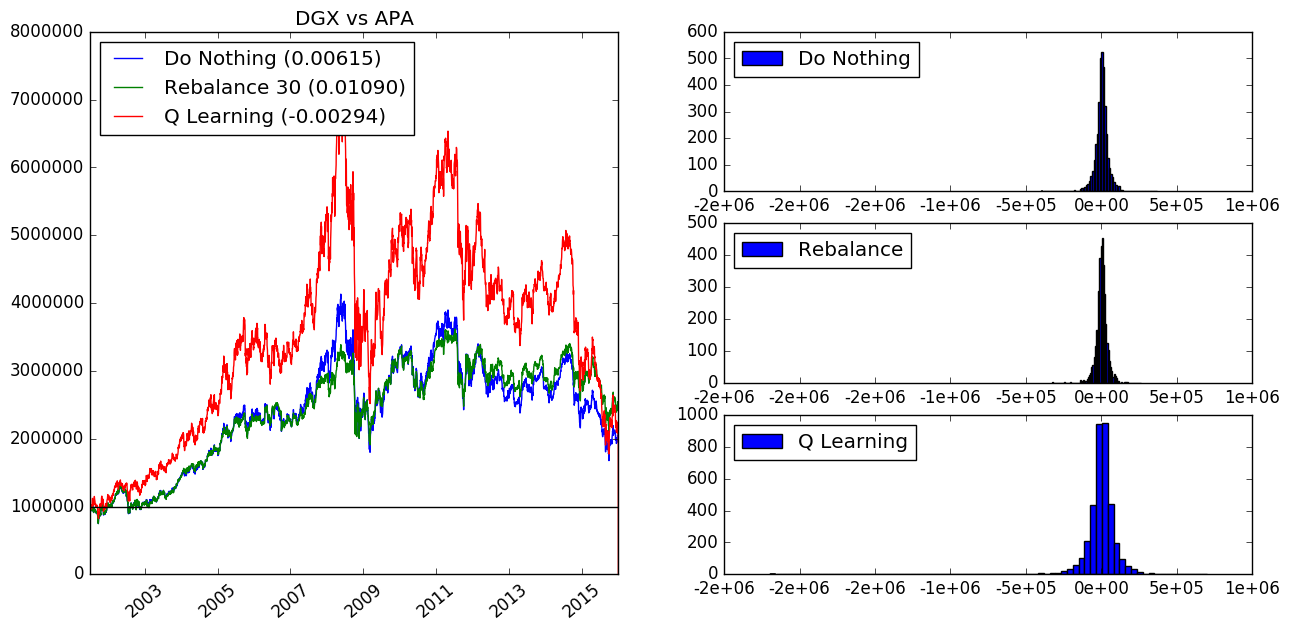

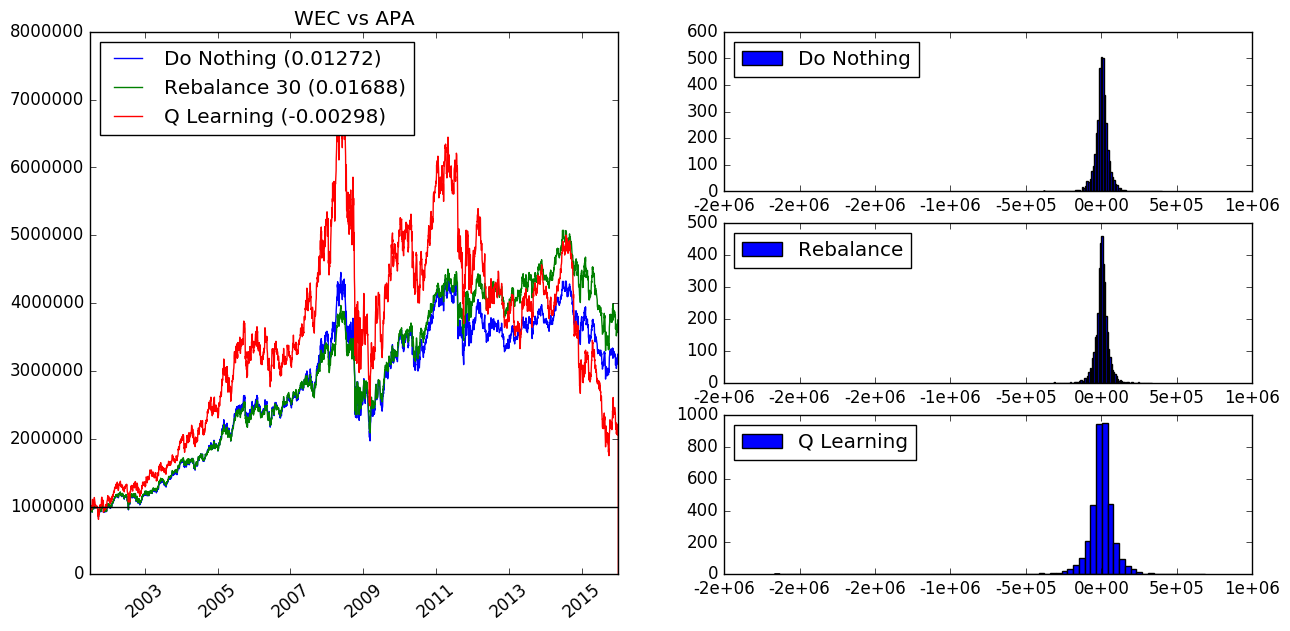

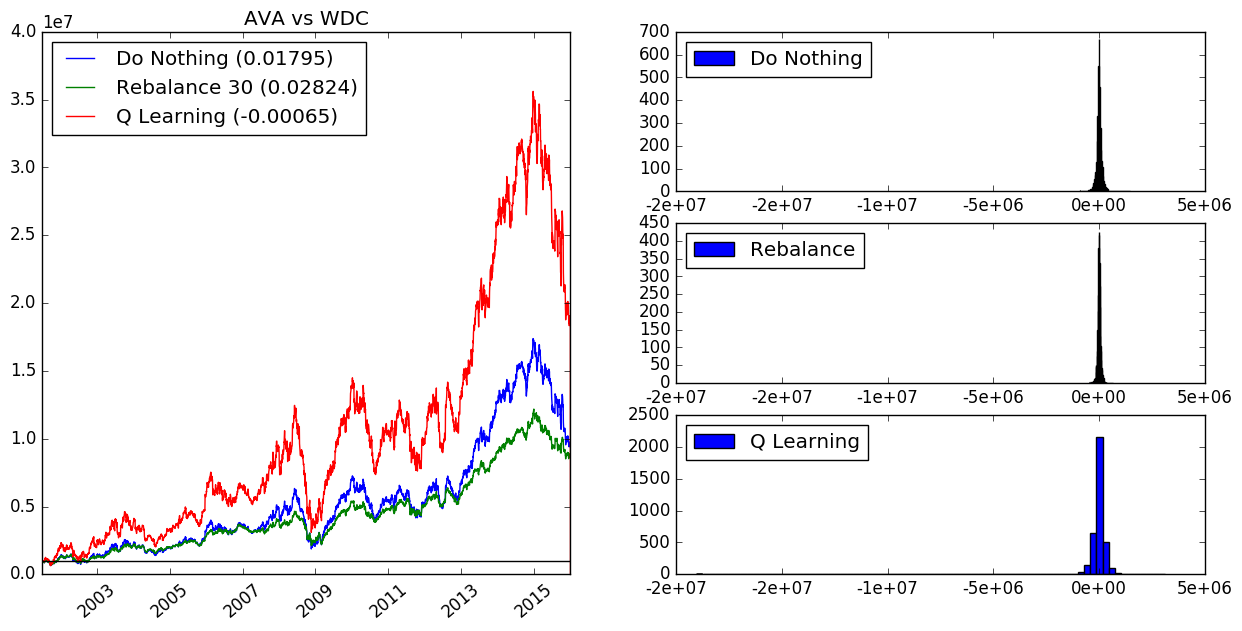

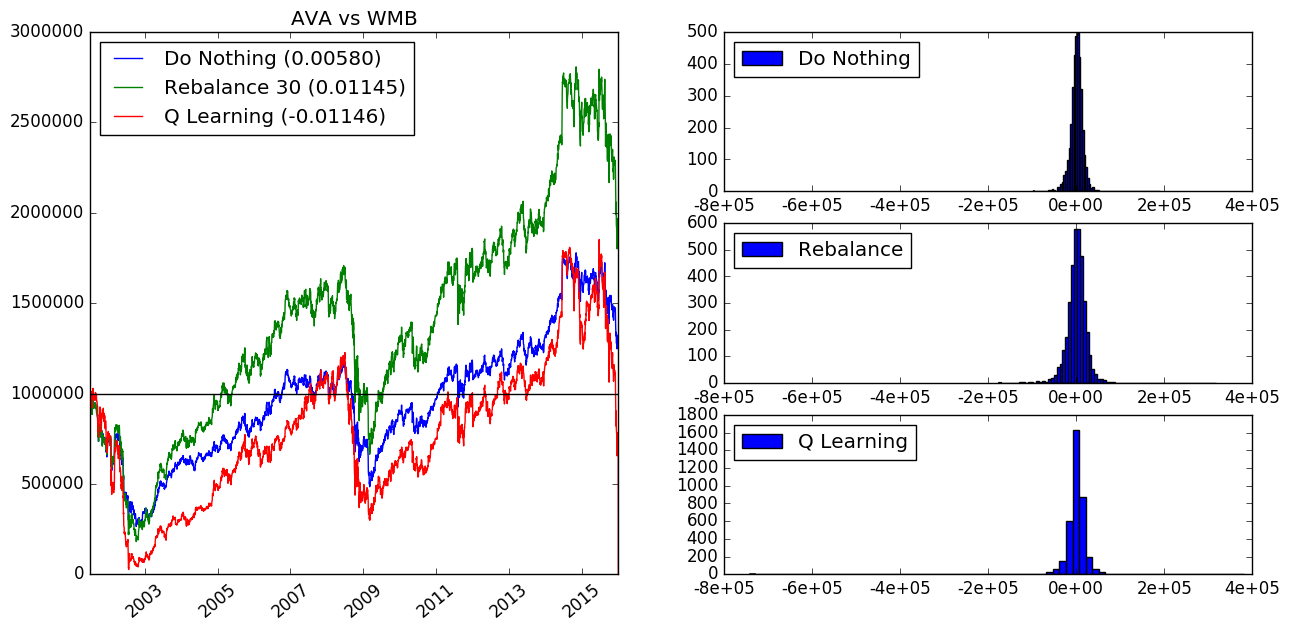

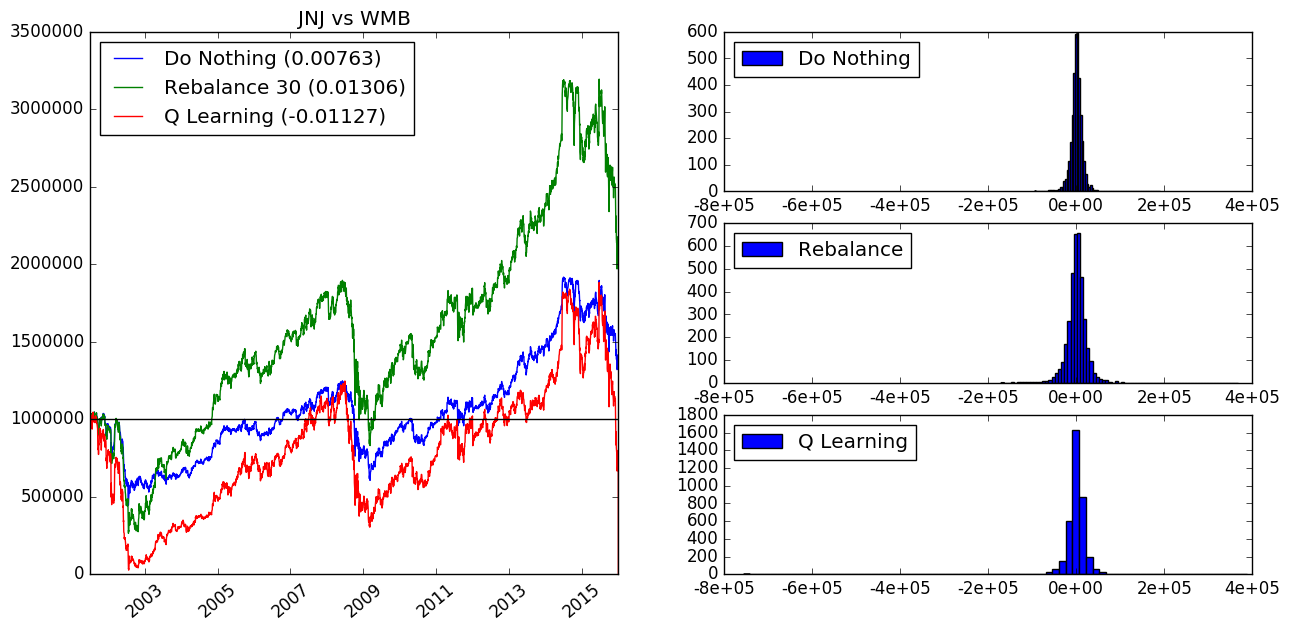

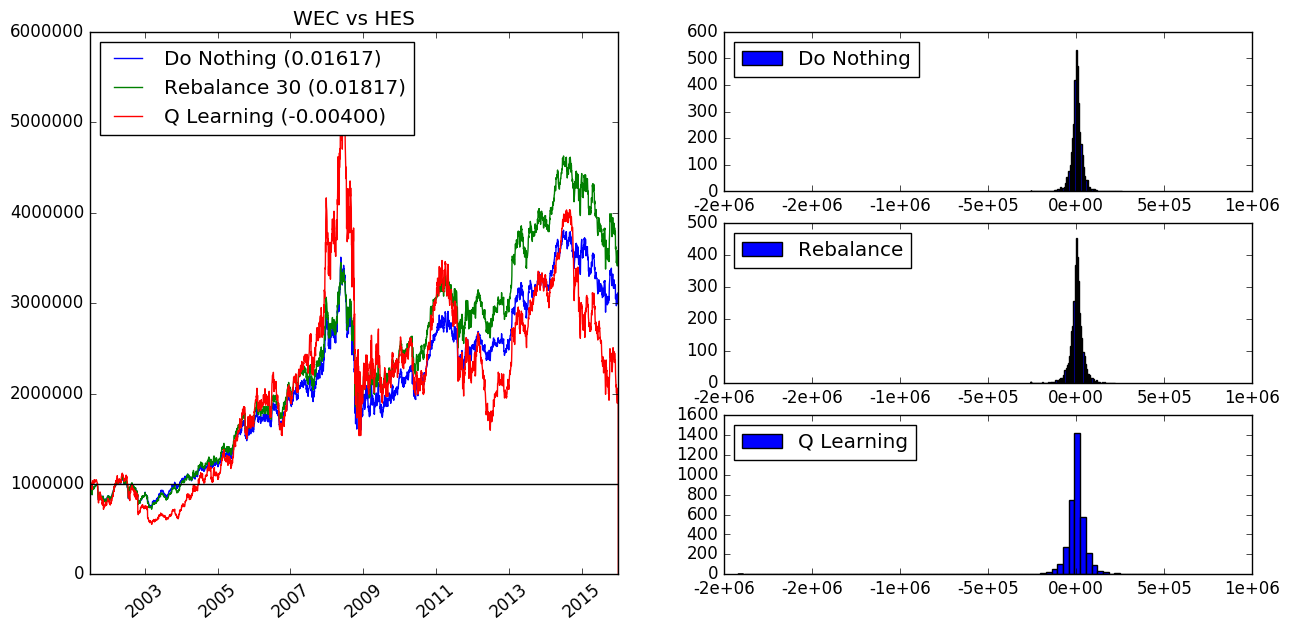

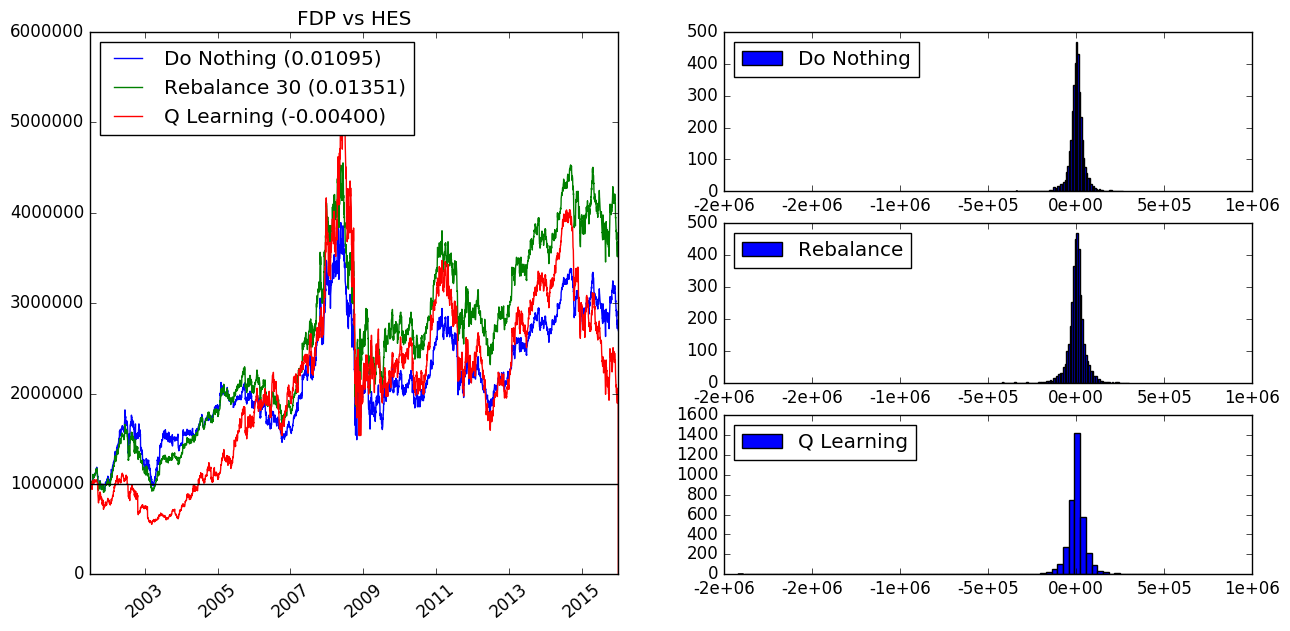

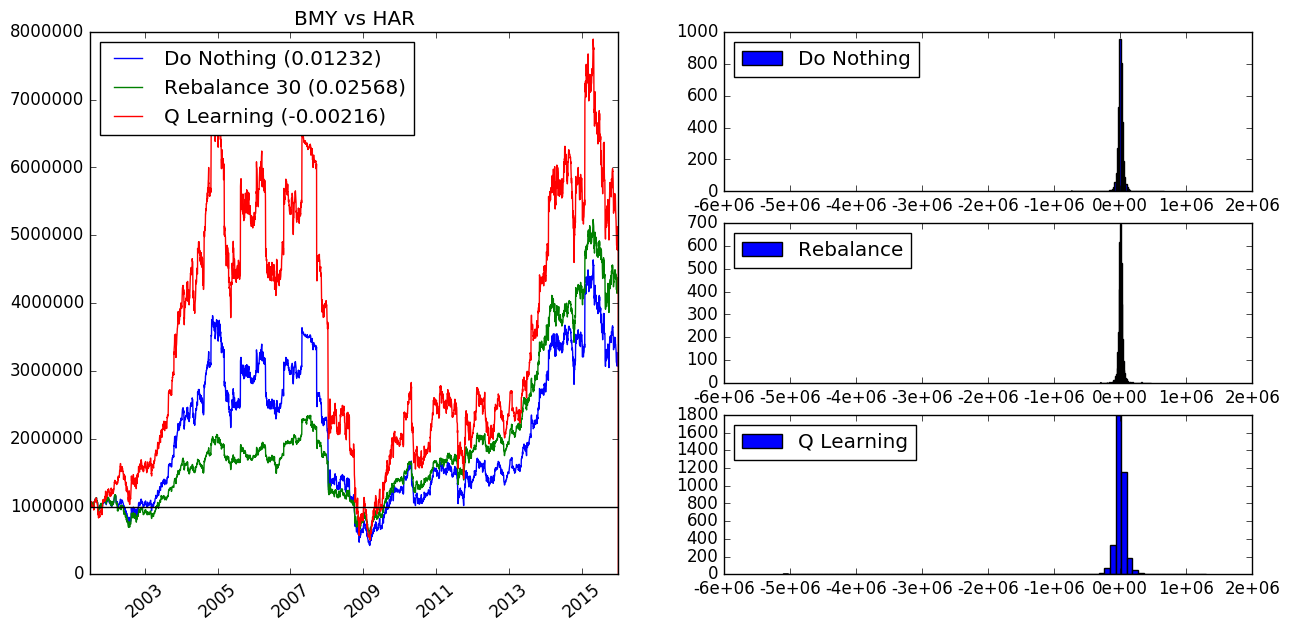

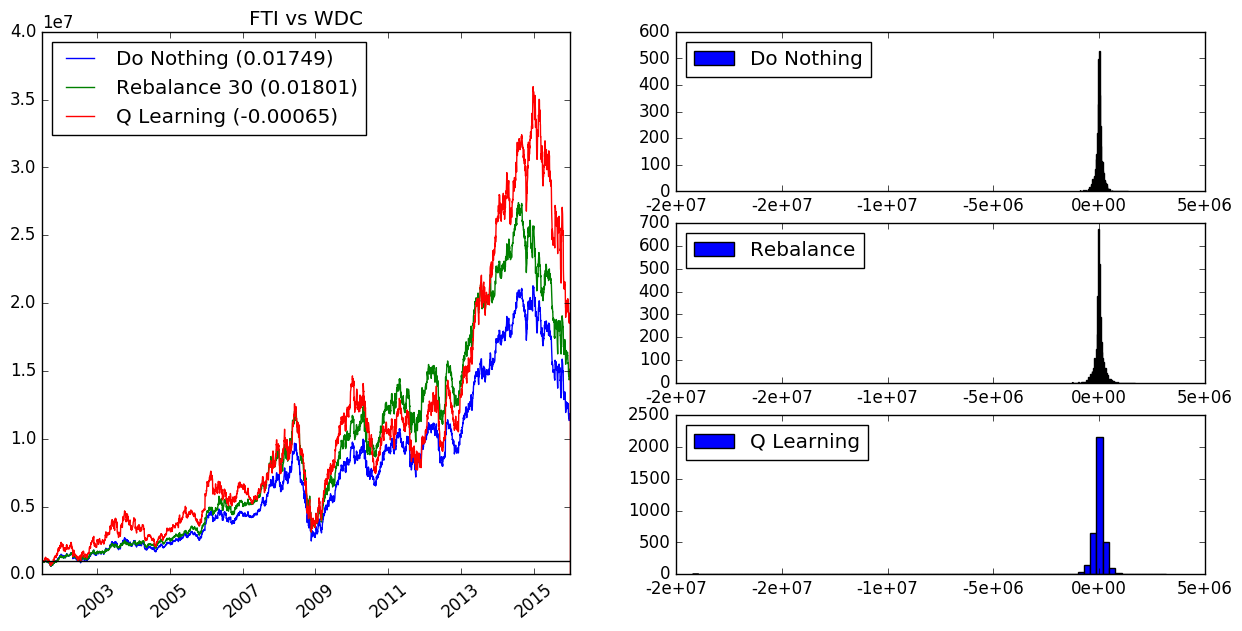

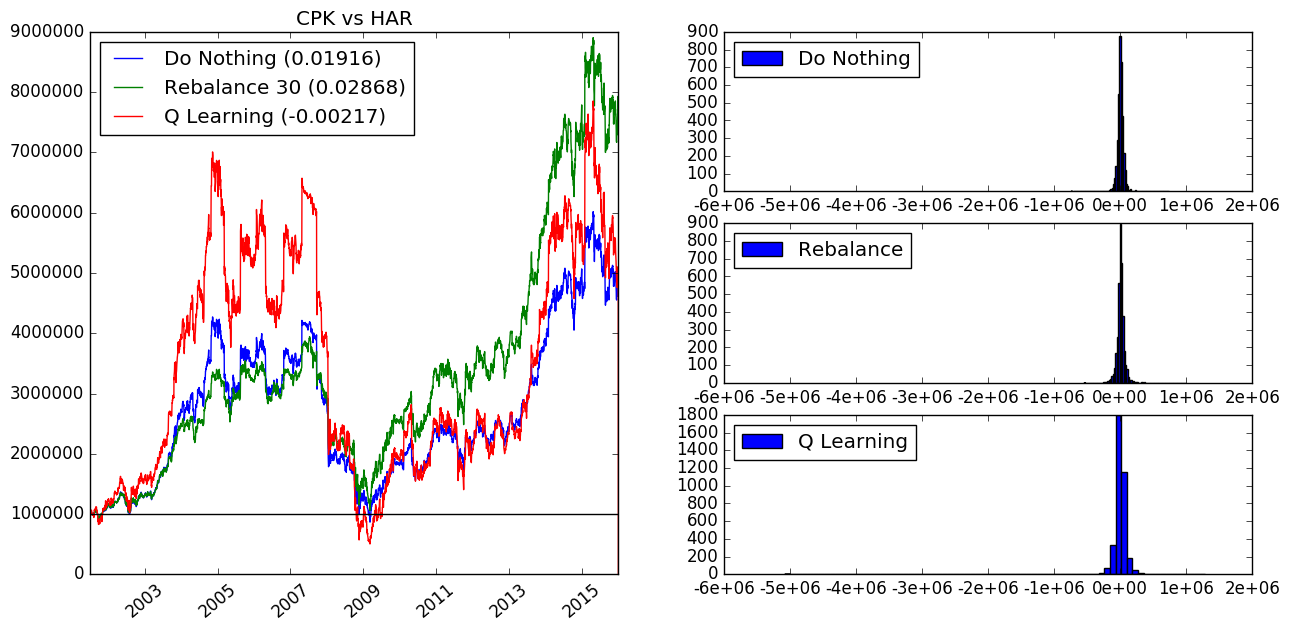

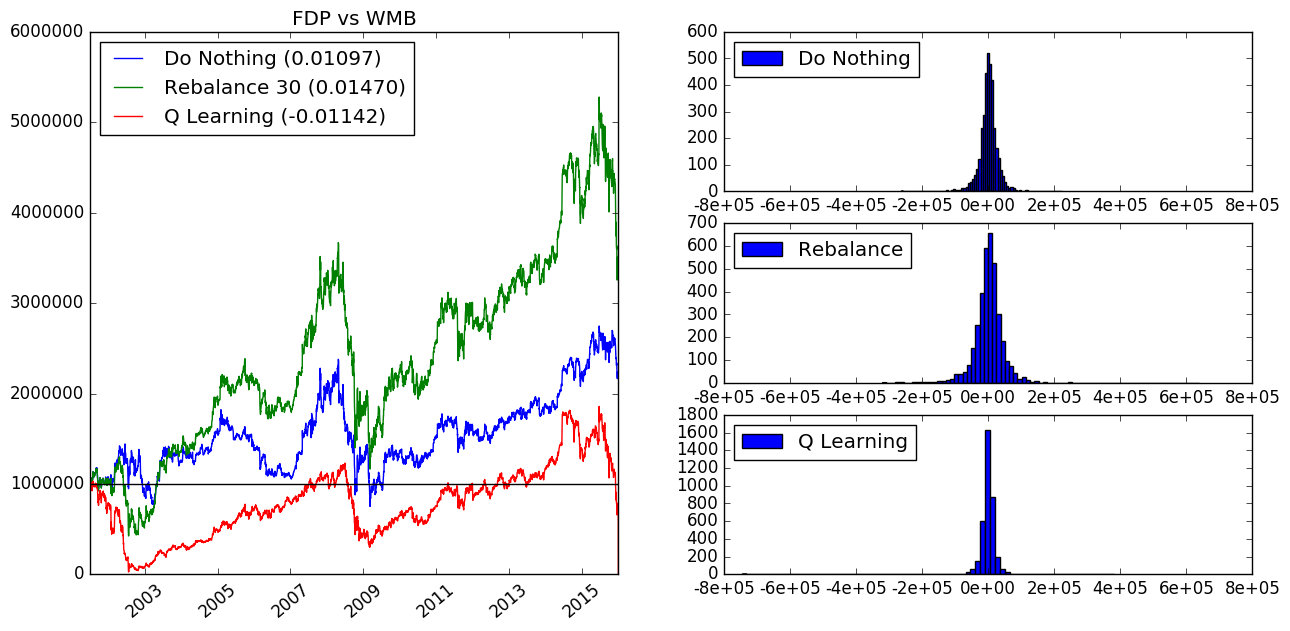

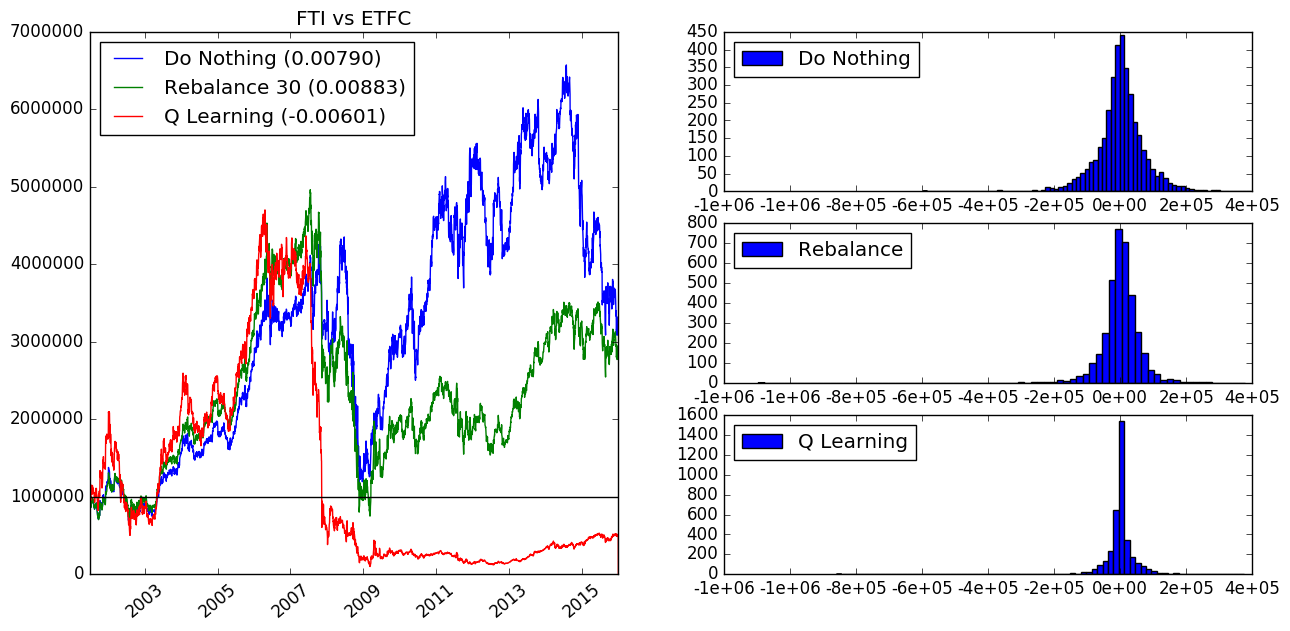

In [104]:
plt.ioff()

bins = 75
fmt = '%.0e'

matplotlib.rc('font', size=12)
lbl_str = '{:s} ({:.5f})'
reward = theta['reward']

for i in range(0, theta['m_test']):
    st = test_states[i]
    nothing = do_nothing_portfolios[i]
    rebal = rebalance_portfolios[i]
    
    # returns for each
    port_returns = trd.portfolio_returns(st.portfolio)
    rebal_returns = trd.portfolio_returns(rebal)
    nothing_returns = trd.portfolio_returns(nothing)

    lo_name = st.lo.symbol
    hi_name = st.hi.symbol
        
    f = plt.figure(figsize=(15, 7))
    
    # portfolio over time
    ax1 = plt.subplot2grid((3, 2), (0,0), rowspan=3)
    cust_plt(ax1, nothing.total, 
             lbl_str.format('Do Nothing', reward(nothing)))
    cust_plt(ax1, rebal.total, 
             lbl_str.format('Rebalance {:d}'.format(rebalance_period), reward(rebal)))
    cust_plt(ax1, st.portfolio.total, 
             lbl_str.format('Q Learning', reward(st.portfolio)))
    
    ax1.axhline(y=theta['cash'], color='black')
    ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    ax1.set_ylim(bottom=0)
    plt.xticks(rotation=40)
    ax1.set_title('{:s} vs {:s}'.format(lo_name, hi_name))

    # histogram of returns
    ax2 = plt.subplot2grid((3, 2), (0,1))
    ax2.hist(nothing_returns, bins, label='Do Nothing')
    ax2.legend(loc='upper left')
    ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter(fmt))
    
    ax3 = plt.subplot2grid((3, 2), (1,1), sharex=ax2)
    ax3.hist(rebal_returns, bins, label='Rebalance')
    ax3.legend(loc='upper left')
    ax3.xaxis.set_major_formatter(mtick.FormatStrFormatter(fmt))
    
    ax4 = plt.subplot2grid((3, 2), (2,1), sharex=ax3)
    ax4.hist(port_returns, bins, label='Q Learning')
    ax4.legend(loc='upper left')
    ax4.xaxis.set_major_formatter(mtick.FormatStrFormatter(fmt))

    # save the picture
    f.savefig(join(MODEL_DIR, '{:s}_{:s}_cmp.png'.format(lo_name, hi_name)))
    

In [118]:
def portfolio_metrics(portfolio, reward):
    rts = trd.portfolio_returns(portfolio)
    return (trd.sharpe_ratio_reward(portfolio), 
            np.mean(rts), np.std(rts, ddof=1), reward(portfolio))

In [119]:
q_perf = []

for st in test_states:
    q_perf.append(portfolio_metrics(st.portfolio, reward))
    
q_perf = np.mean(np.asarray(q_perf), axis=0)
q_perf

array([ -4.01469670e-03,  -2.74572704e+02,   1.35853876e+05,
        -4.01469670e-03])

In [120]:
onothing_perf = []

for p in do_nothing_portfolios:
    nothing_perf.append(portfolio_metrics(p, reward))
    
nothing_perf = np.mean(np.asarray(nothing_perf), axis=0)
nothing_perf

array([  1.03660230e-02,   7.83874448e+02,   6.97637181e+04,
         1.03660230e-02])

In [121]:
rebal_perf = []

for p in rebalance_portfolios:
    rebal_perf.append(portfolio_metrics(p, reward))
    
rebal_perf = np.mean(np.asarray(rebal_perf), axis=0)
rebal_perf

array([  1.45260796e-02,   9.47429129e+02,   6.83230478e+04,
         1.45260796e-02])

In [122]:
np.savetxt(join(MODEL_DIR, 'nothing_perf.csv'), nothing_perf)
np.savetxt(join(MODEL_DIR, 'rebal_perf.csv'), rebal_perf)
np.savetxt(join(MODEL_DIR, 'q_perf.csv'), q_perf)